# IMAGE AND SPEECH RECOGNITION

### Face Mask Detection

Authors:
Mateusz Hryciow,
Mateusz Szewczyk,
Kacper Zagorski

In [107]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
%matplotlib inline

from sklearn import metrics
sn.set_palette("Reds")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models, utils
from torchvision.utils import make_grid
from torch.autograd import Variable

import time
from PIL import Image, ImageOps, ImageDraw, ImageFont
from IPython.display import display

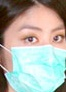

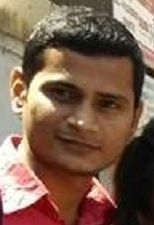

In [3]:
# Examples of data used for training
display(Image.open('./dataset/with_mask/0_0_0 copy 10.jpg'))
display(Image.open('./dataset/without_mask/1.jpg'))

In [5]:
# Data augmentation and normalization
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#needed in order to display the resulting images after they are transformed
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [6]:
train_data = datasets.ImageFolder('./dataset',transform=train_transform)
test_data = datasets.ImageFolder('./dataset',transform=test_transform)
class_names = train_data.classes

In [8]:
# Dividing data into training and test sets
np.random.seed(10)

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]

#balanced sampling (against the classes) + taking only the train indexes
train_sampler = SubsetRandomSampler(train_idx) 
test_sampler = SubsetRandomSampler(test_idx)

In [9]:
batch_size = 10 #only to display images, trained with batch = 100
workers = 0

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, sampler=test_sampler, num_workers=workers)

Class: ['with_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask', 'without_mask', 'with_mask', 'without_mask', 'with_mask', 'without_mask']


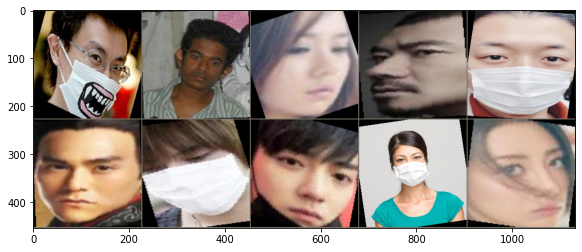

In [10]:
for images,labels in train_loader: 
    break

print('Class:', [class_names[i] for i in labels])

im = make_grid(images, nrow=5)
# denormalazing the images
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
# imshow from matplotlib requires the different order of image dimensions
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [11]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        #(in_chan, out_chan, size, stride, padding)
        self.conv1 = nn.Conv2d(3, 16, 10, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 20, 3, 1)
        # parameter - dropout probability
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9*9*32, 200)
        self.fc2 = nn.Linear(200, 80)
        self.fc3 = nn.Linear(80, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X)) #rectified linear unit - activation function
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.dropout1(X)
        X = X.view(-1, 9*9*32) 
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1) # converting logits to odds

In [12]:
CNNmodel = ConvolutionalNetwork()
CNNmodel.parameters

<bound method Module.parameters of ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(10, 10), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(20, 20), stride=(3, 3), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2592, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)>

In [22]:
def train_model(CNNmodel, criterion, optimizer, epochs):
    start_time = time.time()

    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []

    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0

        for b,(X_train,y_train) in enumerate(train_loader):

            b+=1

            # prediction
            y_pred = CNNmodel(X_train)
            # loss
            loss = criterion(y_pred, y_train)
            
            # predicted class
            predicted = torch.max(y_pred,1)[1]
            # number of correct predictions in batch (sumnming all 1's)
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            # gradient resetting
            optimizer.zero_grad()
            # back propragation
            loss.backward()
            # parameters update
            optimizer.step()
            
            print(f'Epoka: {i}, seria: {b}, strata: {loss}, dokładność: {trn_corr.item()/b:7.3f}%')

        train_losses.append(loss)
        train_correct.append(trn_corr)

        # perform test after each iteration (without parameters update)
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(test_loader):

                y_val = CNNmodel(X_test)

                predicted = torch.max(y_val,1)[1]
                tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)

    total_time = (time.time() - start_time)/60
    
    print(f'Czas uczenia: {total_time} minut.')
    
    return CNNmodel, train_losses, test_losses, train_correct, test_correct

## Training CNN 

In [16]:
batch_size = 100 
workers = 0

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, sampler=test_sampler, num_workers=workers)

In [17]:
# To create different CNNs modify parameters
criterion = nn.CrossEntropyLoss()
CNNmodel = ConvolutionalNetwork()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.00001)
epochs = 40


In [ ]:
result = train_model(CNNmodel, criterion, optimizer, epochs)
CNNmodel,train_losses, test_losses, train_correct, test_correct = result

In [ ]:
# Ploting loss at the end of each epoch
plt.plot([x/(len(train_idx)/100) for x in np.array(train_losses)], label='training')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_losses)], label='testing')
plt.title('Loss at the end of each epoch')
plt.legend()

In [ ]:
# Plotting accuract at the end of each epoch
plt.plot([x/(len(train_idx)/100) for x in np.array(train_correct)], label='training')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_correct)], label='testing')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [ ]:
torch.save(CNNmodel.state_dict(), 'siec_od_lr_00001_ep40.pt')

## Transfer learning - ResNet18

In [156]:
# Loading pretrained ResNet18
res18_mod = models.resnet18(pretrained = True)
print(res18_mod)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [157]:
# Freezing parameters
for param in res18_mod.parameters():
    param.requires_grad = False

In [158]:
# Modifying output of the network
fc_features_num = res18_mod.fc.in_features
res18_mod.fc = nn.Linear(fc_features_num, 2)
print(res18_mod)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [159]:
# To create different ResNet18 classifiers modify parameters
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, sampler=test_sampler, num_workers=workers)

In [ ]:
optimizer = torch.optim.SGD(res18_mod.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
result_18 = train_model(res18_mod, criterion, optimizer, 10)

In [ ]:
res18_mod,train_losses, test_losses, train_correct, test_correct = result_18

In [ ]:
# Ploting accuracy at the end of each epoch
plt.plot([x/(len(train_idx)/100) for x in np.array(train_correct)], label='training')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_correct)], label='testing')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [ ]:
# Ploting loss at the end of each epoch
plt.plot([x/(len(train_idx)/100) for x in np.array(train_losses)], label='training')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_losses)], label='testing')
plt.title('Loss at the end of each epoch')
plt.legend()

In [ ]:
torch.save(res18_mod, 'model_transfer_res18.pt')

## Face extractor
Source: https://github.com/kb22/Create-Face-Data-from-Images

In [114]:
def extract_faces(path,face_model):
  image = cv2.imread(path)
  (h, w) = image.shape[:2]
  # Finding all possible faces
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  face_model.setInput(blob)
  detections = face_model.forward()

  faces = []
  # Showing image 
  img = Image.open(path)
  img = np.array(img)
  fig,ax = plt.subplots(1)
  ax.grid(False)
  fig.set_size_inches(16,8)
  ax.imshow(img)


  # Loop through all images and strip out faces
  count = 0
  for i in range(0, detections.shape[2]):
    box = detections[0,0,i,3:7] * np.array([w,h,w,h])
    # Extracting borders
    startX, startY, endX, endY = box.astype("int")
    confidence = detections[0,0,i,2]
    # If confidentce is grater than 0.5 it is face, so save it
    if confidence > 0.5:
      count += 1
      frame = image[startY:endY, startX:endX]
      faces.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

      # Adding rectangle border around face to image
      rect = patches.Rectangle((startX,startY),endX-startX,endY-startY,linewidth=1,edgecolor='r',facecolor='none')
      ax.add_patch(rect)

  # In order to get every face use: faces[0] - first face, faces[1] - second face, etc.
  return faces

In [115]:
# Reading face extraction model from files
prototxt_path = os.path.join('model_data/deploy.prototxt')
caffemodel_path = os.path.join('model_data/weights.caffemodel')
face_model = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)

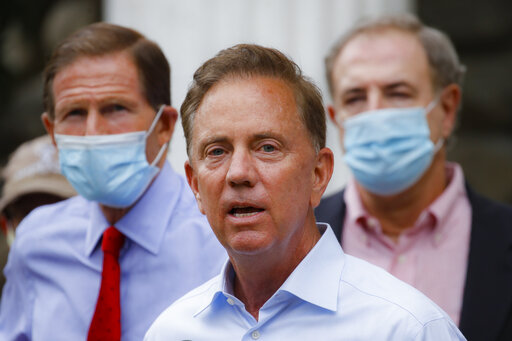

In [123]:
img = Image.open('EIASR_test_photos/img4.jpg')
display(img)

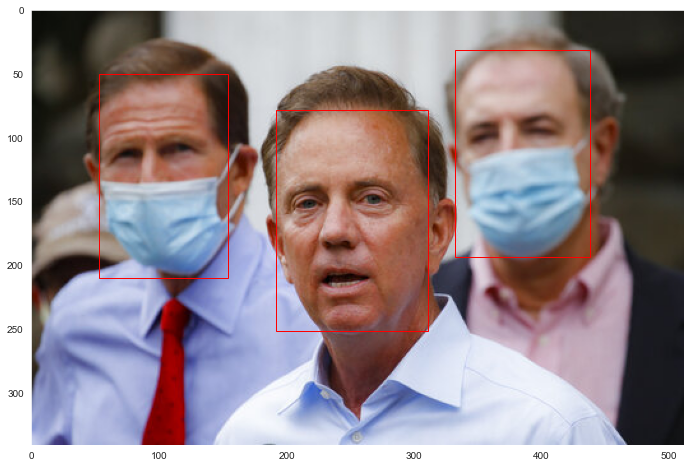

In [124]:
faces = extract_faces('EIASR_test_photos/img4.jpg', face_model)

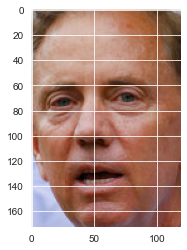

In [126]:
plt.imshow(faces[0])


## Loading already trained CNNs from file

In [64]:
# Link to our github to download networks https://github.com/matszewczyk/projekt-eiasr
CNNmodel40 = ConvolutionalNetwork()
CNNmodel100 = ConvolutionalNetwork()
CNNmodel100ac = ConvolutionalNetwork()
CNNmodel40.load_state_dict(torch.load('siec_od_0_95%_lr_00001_ep40.pt'))
CNNmodel100.load_state_dict(torch.load('siec_od_0_95%_lr_00001_ep100.pt'))
CNNmodel100ac.load_state_dict(torch.load('siec_od_0_100%_lr_0001_ep100.pt'))

# Link to google drive to download resnet18 https://drive.google.com/file/d/1zq8s2OKOh5OILNQfMOjt_VaZz29VJfHm/view?usp=sharing
res18_mod = torch.load('model_transfer_res18.pt')

In [65]:
res18_mod.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Evaluating predictions of neural networks 

In [43]:
# Predictions 
class_list40 =[]
for i, label in test_data:
    image_tensor = i.unsqueeze(0) 
    with torch.no_grad():
        output = CNNmodel40(image_tensor)
    pos = output[0].argmax()
    class_list40.append([class_names[pos], label])

c:\users\mateusz\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [47]:
class_list100 =[]
for i, label in test_data:
    image_tensor = i.unsqueeze(0) 
    with torch.no_grad():
        output = CNNmodel100(image_tensor)
    pos = output[0].argmax()
    class_list100.append([class_names[pos], label])

In [48]:
class_list100ac =[]
for i, label in test_data:
    image_tensor = i.unsqueeze(0) 
    with torch.no_grad():
        output = CNNmodel100ac(image_tensor)
    pos = output[0].argmax()
    class_list100ac.append([class_names[pos], label])

In [67]:
class_listRes =[]
for i, label in test_data:
    image_tensor = i.unsqueeze(0) 
    with torch.no_grad():
        output = res18_mod(image_tensor)
    pos = output[0].argmax()
    class_listRes.append([class_names[pos], label])

c:\users\mateusz\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [182]:
df40 = pd.DataFrame(class_list40, columns=['Predicted', 'Real'])
df100 = pd.DataFrame(class_list100, columns=['Predicted', 'Real'])
df100ac = pd.DataFrame(class_list100ac, columns=['Predicted', 'Real'])

dfRes = pd.DataFrame(class_listRes, columns=['Predicted', 'Real'])

In [183]:
df40.loc[df40.Predicted == 'with_mask', "Predicted"] = 0
df40.loc[df40.Predicted == 'without_mask', "Predicted"] = 1
df100.loc[df100.Predicted == 'with_mask', "Predicted"] = 0
df100.loc[df100.Predicted == 'without_mask', "Predicted"] = 1
df100ac.loc[df100ac.Predicted == 'with_mask', "Predicted"] = 0
df100ac.loc[df100ac.Predicted == 'without_mask', "Predicted"] = 1

dfRes.loc[dfRes.Predicted == 'with_mask', "Predicted"] = 0
dfRes.loc[dfRes.Predicted == 'without_mask', "Predicted"] = 1

In [184]:
#example of dataframe
df40

Predicted  Real
0            0     0
1            0     0
2            0     0
3            0     0
4            0     0
...        ...   ...
3862         1     1
3863         1     1
3864         1     1
3865         0     1
3866         0     1

[3867 rows x 2 columns]

## Confusion matrices  

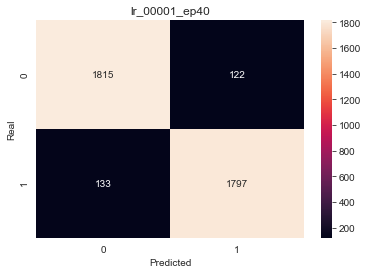

In [185]:
conf_matr40 =pd.crosstab(df40["Real"], df40["Predicted"], rownames=["Real"], colnames=["Predicted"])
sn.set_style('darkgrid')
sn.heatmap(conf_matr40, annot=True, fmt='g')
plt.title("lr_00001_ep40")
plt.show()

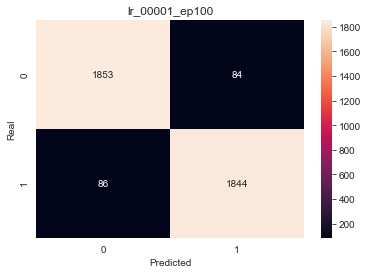

In [186]:
conf_matr100 =pd.crosstab(df100["Real"], df100["Predicted"], rownames=["Real"], colnames=["Predicted"])
sn.set_style('darkgrid')
sn.heatmap(conf_matr100, annot=True, fmt='g')
plt.title("lr_00001_ep100")
plt.show()

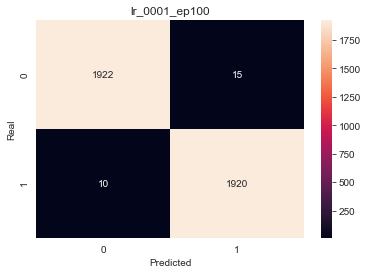

In [187]:
conf_matr100ac =pd.crosstab(df100ac["Real"], df100ac["Predicted"], rownames=["Real"], colnames=["Predicted"])
sn.set_style('darkgrid')
sn.heatmap(conf_matr100ac, annot=True, fmt='g')
plt.title("lr_0001_ep100")
plt.show()

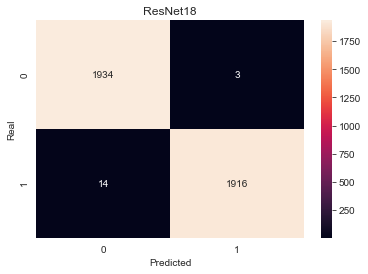

In [188]:
conf_matrRes =pd.crosstab(dfRes["Real"], dfRes["Predicted"], rownames=["Real"], colnames=["Predicted"])
sn.set_style('darkgrid')
sn.heatmap(conf_matrRes, annot=True, fmt='g')
plt.title("ResNet18")
plt.show()

In [75]:
TPR40 = (conf_matr40[0][0])/(conf_matr40[0][0] + conf_matr40[1][0])
TNR40 = (conf_matr40[1][1])/(conf_matr40[1][1] + conf_matr40[0][1])
FPR40 = (conf_matr40[0][1])/(conf_matr40[0][1] + conf_matr40[1][1])
FNR40 = (conf_matr40[1][0])/(conf_matr40[1][0] + conf_matr40[0][0])
ACC40 = (conf_matr40[0][0] + conf_matr40[1][1])/(conf_matr40[1][0] + conf_matr40[1][1]+conf_matr40[0][0] + conf_matr40[0][1])

TPR100 = (conf_matr100[0][0])/(conf_matr100[0][0] + conf_matr100[1][0])
TNR100 = (conf_matr100[1][1])/(conf_matr100[1][1] + conf_matr100[0][1])
FPR100 = (conf_matr100[0][1])/(conf_matr100[0][1] + conf_matr100[1][1])
FNR100 = (conf_matr100[1][0])/(conf_matr100[1][0] + conf_matr100[0][0])
ACC100 = (conf_matr100[0][0] + conf_matr100[1][1])/(conf_matr100[1][0] + conf_matr100[1][1]+conf_matr100[0][0] + conf_matr100[0][1])

TPR100ac = (conf_matr100ac[0][0])/(conf_matr100ac[0][0] + conf_matr100ac[1][0])
TNR100ac = (conf_matr100ac[1][1])/(conf_matr100ac[1][1] + conf_matr100ac[0][1])
FPR100ac = (conf_matr100ac[0][1])/(conf_matr100ac[0][1] + conf_matr100ac[1][1])
FNR100ac = (conf_matr100ac[1][0])/(conf_matr100ac[1][0] + conf_matr100ac[0][0])
ACC100ac = (conf_matr100ac[0][0] + conf_matr100ac[1][1])/(conf_matr100ac[1][0] + conf_matr100ac[1][1]+conf_matr100ac[0][0] + conf_matr100ac[0][1])

TPRRes = (conf_matrRes[0][0])/(conf_matrRes[0][0] + conf_matrRes[1][0])
TNRRes = (conf_matrRes[1][1])/(conf_matrRes[1][1] + conf_matrRes[0][1])
FPRRes = (conf_matrRes[0][1])/(conf_matrRes[0][1] + conf_matrRes[1][1])
FNRRes = (conf_matrRes[1][0])/(conf_matrRes[1][0] + conf_matrRes[0][0])
ACCRes = (conf_matrRes[0][0] + conf_matrRes[1][1])/(conf_matrRes[1][0] + conf_matrRes[1][1]+conf_matrRes[0][0] + conf_matrRes[0][1])

In [84]:
stats40 = pd.DataFrame([["TPR",TPR40],["TNR",TNR40],["FPR",FPR40],["FNR",FNR40],["ACC",ACC40]], columns=["Stats","Value"])
stats100 = pd.DataFrame([["TPR",TPR100],["TNR",TNR100],["FPR",FPR100],["FNR",FNR100],["ACC",ACC100]], columns=["Stats","Value"])
stats100ac = pd.DataFrame([["TPR",TPR100ac],["TNR",TNR100ac],["FPR",FPR100ac],["FNR",FNR100ac],["ACC",ACC100ac]], columns=["Stats","Value"])

c:\users\mateusz\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


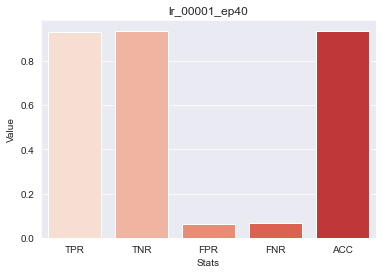

In [86]:
sn.barplot(stats40["Stats"], stats40["Value"])
plt.title("lr_00001_ep40")
plt.show()

c:\users\mateusz\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


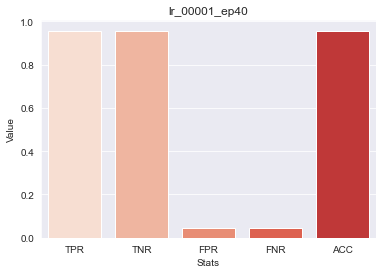

In [87]:
sn.barplot(stats100["Stats"], stats100["Value"])
plt.title("lr_00001_ep40")
plt.show()

c:\users\mateusz\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


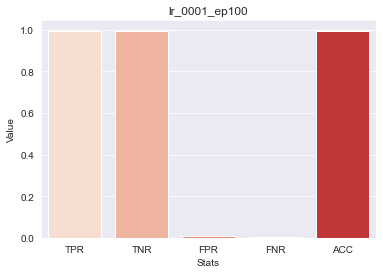

In [88]:
sn.barplot(stats100ac["Stats"], stats100ac["Value"],)
plt.title("lr_0001_ep100")
plt.show()

c:\users\mateusz\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


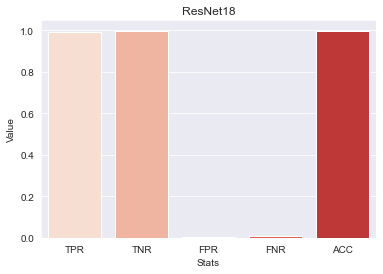

In [78]:
statsRes = pd.DataFrame([["TPR",TPRRes],["TNR",TNRRes],["FPR",FPRRes],["FNR",FNRRes],["ACC",ACCRes]], columns=["Stats","Value"])
sn.barplot(statsRes["Stats"], statsRes["Value"],)
plt.title("ResNet18")
plt.show()

## Deep Dream 

In [89]:
#This part is taken from fast.ai course, it allows to attach a hook to a model or its certain layer
#Sadly i cant find working link anymore as i had this cell in my disc for a long time
#So this will rather not be included in our report
#Just did it to get some knoledge how our network works
class SaveFeatures():
    def __init__(self, m, backward=False): 
      if backward==False:
        self.hook = m.register_forward_hook(self.hook_fn)
      else:
        self.hook = m.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
      self.features = ((output.cpu()).data).numpy()
      self.input = input
      self.output = output
    def remove(self): self.hook.remove()

In [91]:
def calc_grad(tensor, model):     
  var = Variable((tensor.unsqueeze(0)).cpu(), requires_grad=True)
  model.zero_grad() #we need to set the gradients to zero as torch tends to acumulate it 
  feature = SaveFeatures(model)
  pred = model(var)
  loss = feature.output[0].norm()
  loss.backward()
  return var.grad.data.squeeze()

In [92]:
denorm = transforms.Compose([ transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1/0.229, 1/0.224, 1/0.225 ])])

In [93]:
#This cell is also an effet of massive stack overflow abusse
#as i have been encountering issues almost in each line
#therefore there are at least several sources behind it
#but i woudnt say that this is a copy of something that exists

def dream(image, model, iterations, res):
  tensor = test_transform(image)
  for i in range(iterations):
    grad = calc_grad(tensor, model)
    tensor.data = tensor.data + res * grad.data

  img_out = tensor.detach().cpu()
  img_out = denorm(img_out)
  img_out_np = img_out.numpy().transpose(1,2,0)
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
  return img_out_pil

In [95]:
def dreamImg(Img, model, it, res):
  img = Image.open(Img)
  dimg = dream(img, model, it, res)

  fig = plt.figure(figsize = (10 , 10))
  plt.imshow(dimg)

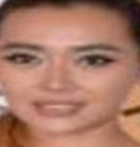

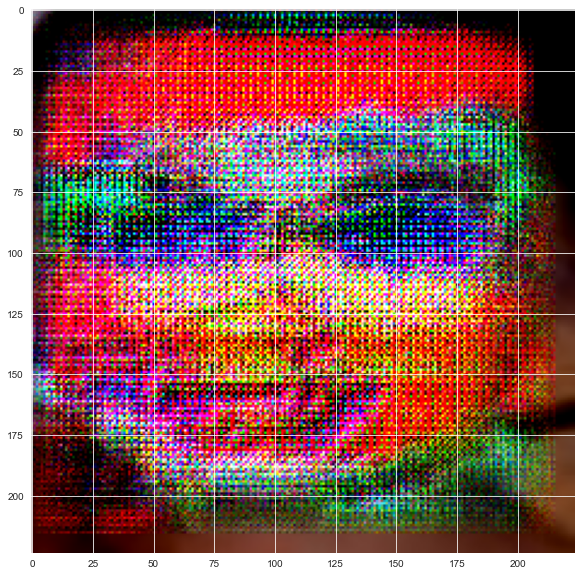

In [102]:
display(Image.open("dataset/without_mask/0_0_aidai_0014.jpg"))
dreamImg("dataset/without_mask/0_0_aidai_0014.jpg", CNNmodel100ac, 1000, 5)

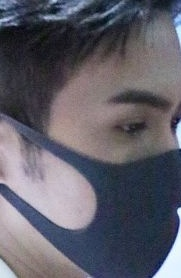

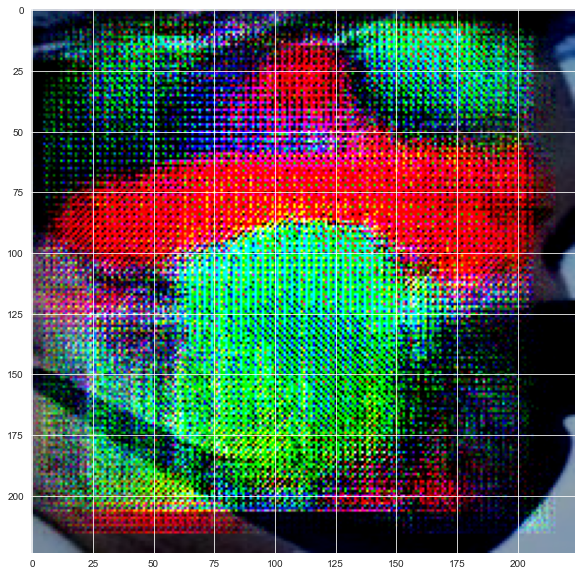

In [103]:
display(Image.open("dataset/with_mask/0_0_1 copy 13.jpg"))
dreamImg("dataset/with_mask/0_0_1 copy 13.jpg", CNNmodel100ac, 1000, 5)

## Testing on single images 

In [105]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load('siec_od_0_95%_lr_00001_ep40.pt'))

<All keys matched successfully>

In [137]:
def predict(image,model):
    image = test_transform(image).unsqueeze(0) #adding the "batch dimension"
    
    with torch.no_grad():
        output = model(image)
    pos = output[0].argmax()
    image = inv_normalize(image.squeeze(0))
    image = np.transpose(image.numpy(), (1, 2, 0))
    image = Image.fromarray((image*255).astype(np.uint8))
    font = ImageFont.truetype('./font.ttf', 18)
    d = ImageDraw.Draw(image)
    d.text((100,200), class_names[pos], fill="#0EDBE1", font=font)
    
    return image

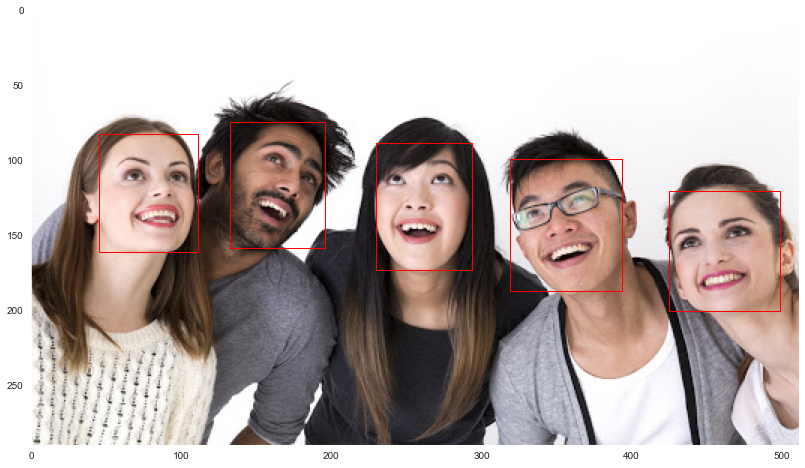

In [140]:
faces = extract_faces('test_new_data/img3.jpg', face_model)

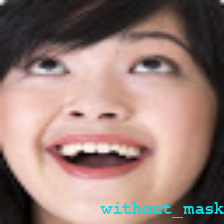

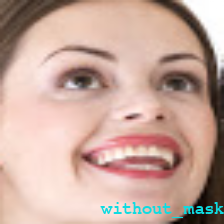

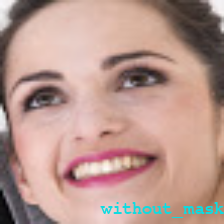

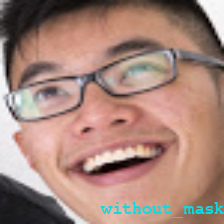

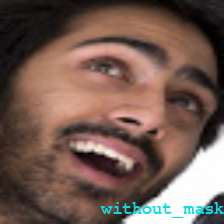

In [141]:
for face in faces:
    img = predict(face,model)
    display(img)

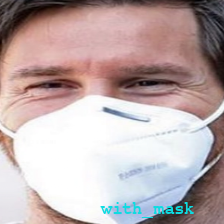

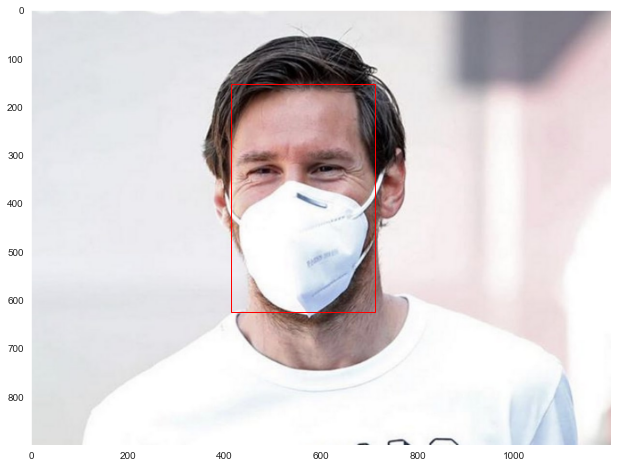

In [154]:
faces = extract_faces('test_new_data/messi_mask.jpg', face_model)
for face in faces:
    img = predict(face,model)
    display(img)

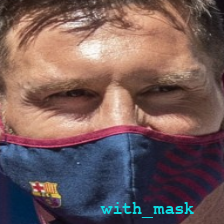

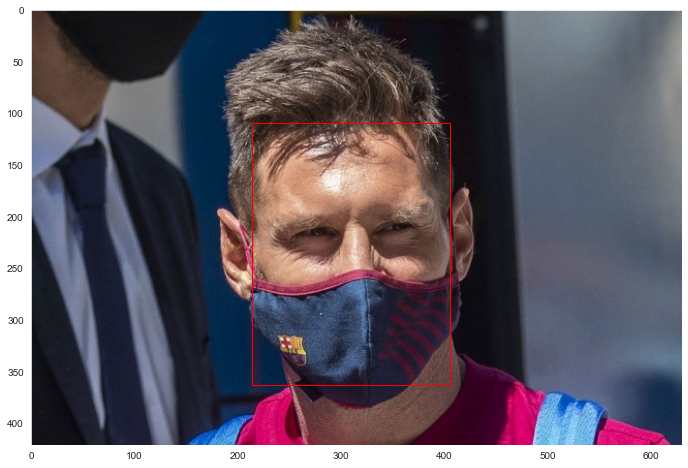

In [148]:
faces = extract_faces('test_new_data/messi_with_mask.jpg', face_model)
for face in faces:
    img = predict(face,model)
    display(img)

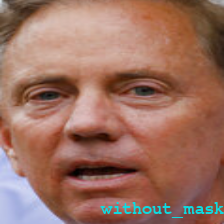

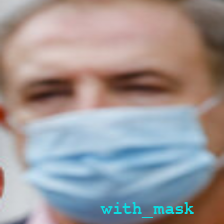

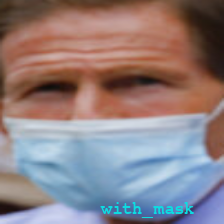

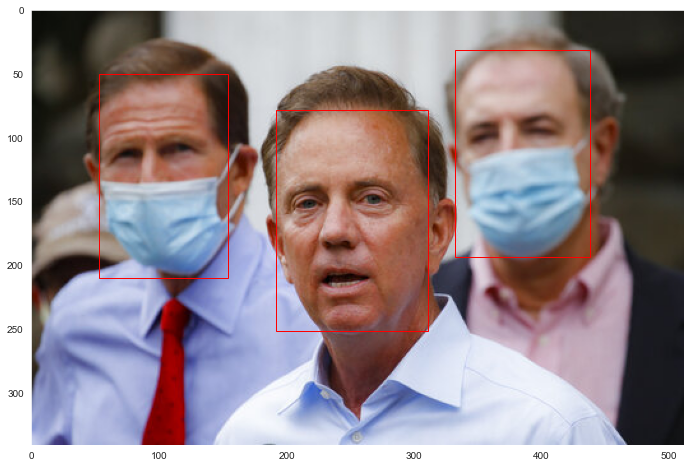

In [147]:
faces = extract_faces('test_new_data/img4.jpg', face_model)
for face in faces:
    img = predict(face,model)
    display(img)

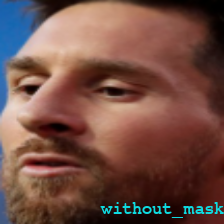

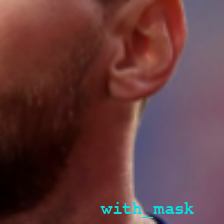

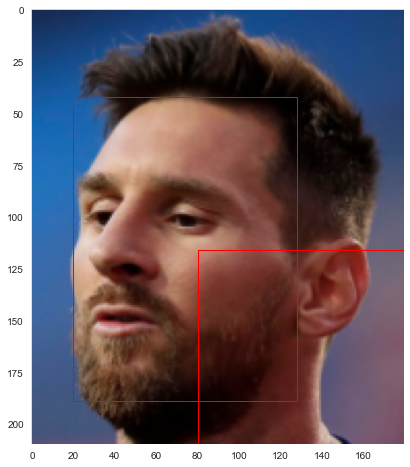

In [217]:
faces = extract_faces('test_new_data/Untitled.png', face_model)
for face in faces:
    img = predict(face,model)
    display(img)